In [6]:
%matplotlib inline

In [80]:
from typing import List, Optional, Iterable, Dict, Any
from itertools import islice
from functools import lru_cache, partial
from dataclasses import dataclass


import pandas as pd
from pandas.tseries.frequencies import to_offset
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm.auto as tqdm
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset, interleave_datasets
from datasets.iterable_dataset import RandomlyCyclingMultiSourcesExamplesIterable

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from gluonts.core.component import validated
from gluonts.dataset.common import Dataset, ListDataset, DatasetCollection, ProcessDataEntry
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, PseudoShuffled, IterableSlice
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    MinuteOfHour,
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
)
from gluonts.torch.modules.loss import DistributionLoss, NegativeLogLikelihood
from gluonts.transform import (
    Transformation,
    Chain,
    RemoveFields,
    SetField,
    AsNumpyArray,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AddAgeFeature,
    VstackFeatures,
    InstanceSplitter,
    ValidationSplitSampler,
    TestSplitSampler,
    ExpectedNumInstanceSampler,
    SelectFields,
    InstanceSampler,
)
from gluonts.torch.util import (
    IterableDataset,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.model.estimator import PyTorchLightningEstimator
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import (
    DistributionOutput,
    StudentTOutput,
)
from gluonts.torch.util import weighted_average
from gluonts.torch.modules.scaler import MeanScaler, NOPScaler
from gluonts.torch.modules.feature import FeatureEmbedder
from gluonts.time_feature import get_lags_for_frequency
from gluonts.dataset.repository.datasets import get_dataset

In [81]:
time_features=[
        MinuteOfHour(),
        HourOfDay(),
        DayOfWeek(),
        DayOfMonth(),
        DayOfYear(),
    ]

def add_time_feature(data, freq):
    length = len(data[FieldName.TARGET])
    start = pd.Period(data[FieldName.START], freq)
    index = pd.period_range(start, periods=length, freq=freq)

    data[FieldName.FEAT_TIME] = np.vstack(
        [feat(index) for feat in time_features]
    ).astype(np.float32)
    
    age = np.log10(2.0 + np.arange(length, dtype=np.float32))
    data[FieldName.FEAT_AGE] = age.reshape((1, length))
    return data

In [82]:
@lru_cache(10_000)
def _as_period(val, freq):
    return pd.Period(val, freq)

@dataclass
class HFDataset(Dataset):
    def __init__(self, dataset, freq, shuffle=False):
        super().__init__()
        transform = partial(add_time_feature, freq=freq)
        self.dataset = dataset.with_format("np").map(
            transform,  num_proc=8, keep_in_memory=False,
        )
        if shuffle:
            self.dataset = self.dataset.shuffle()
        self.freq = to_offset(freq)
    
    def __iter__(self):
        for data in self.dataset:
            yield {
                FieldName.START: _as_period(data[FieldName.START], self.freq),
                FieldName.TARGET: data[FieldName.TARGET],
                FieldName.ITEM_ID: data[FieldName.ITEM_ID],
                FieldName.FEAT_TIME: np.stack(data[FieldName.FEAT_TIME],0),
                FieldName.FEAT_AGE: np.stack(data[FieldName.FEAT_AGE],0),
            }

    def __len__(self) -> int:
        return len(self.dataset)

In [83]:
dataset_1 = load_dataset("monash_tsf", "traffic_hourly")

  0%|          | 0/3 [00:00<?, ?it/s]

In [84]:
dataset_2 = load_dataset("monash_tsf", "weather")

  0%|          | 0/3 [00:00<?, ?it/s]

In [85]:
dataset_3 = load_dataset("monash_tsf", "tourism_monthly")

  0%|          | 0/3 [00:00<?, ?it/s]

In [227]:
dataset_4 = load_dataset("monash_tsf", "london_smart_meters")

  0%|          | 0/3 [00:00<?, ?it/s]

In [276]:
len(dataset_1["train"])

862

In [178]:
len(dataset_2["train"])

3010

In [179]:
len(dataset_3["train"])

366

In [279]:
len(dataset_4["train"])

5560

In [229]:
train_ds_1 = HFDataset(dataset_1["train"], freq="1H", shuffle=True)

In [230]:
train_ds_2 = HFDataset(dataset_2["train"], freq="1D", shuffle=True)

In [88]:
train_ds_3 = HFDataset(dataset_3["train"], freq="1M", shuffle=True)

In [231]:
train_ds_4 = HFDataset(dataset_4["train"], freq="30T", shuffle=True)

In [180]:
val_ds_1 = HFDataset(dataset_1["validation"], freq="1H",  shuffle=True)

In [181]:
val_ds_2 = HFDataset(dataset_2["validation"], freq="1D",  shuffle=True)

In [182]:
val_ds_3 = HFDataset(dataset_3["validation"], freq="1M",  shuffle=True)

In [232]:
val_ds_4 = HFDataset(dataset_4["validation"], freq="30T",  shuffle=True)

In [92]:
test_ds_1 = HFDataset(dataset_1["test"], freq="1H",)

In [93]:
test_ds_2 = HFDataset(dataset_2["test"], freq="1D",)

In [94]:
test_ds_3 = HFDataset(dataset_3["test"], freq="1M",)

In [233]:
test_ds_4 = HFDataset(dataset_4["test"], freq="30T",)

In [281]:
train_ds_list = [train_ds_1, train_ds_2, train_ds_3, train_ds_4]
train_ds_size = np.array([len(ds) for ds in train_ds_list])
raw_weights = 1/train_ds_size
normalization_factor = 1/sum(raw_weights)
probablities = raw_weights * normalization_factor

In [283]:
train_ds = RandomlyCyclingMultiSourcesExamplesIterable(
    train_ds_list, 
    generator=np.random.default_rng(), 
    probabilities=probablities,
)

In [284]:
val_ds = DatasetCollection(datasets=[val_ds_1, val_ds_2, val_ds_3], interleave=True)

In [246]:
class TransformerModel(nn.Module):
    @validated()
    def __init__(
        self,
        context_length: int,
        prediction_length: int,
        num_feat_dynamic_real: int,
        num_feat_static_real: int,
        num_feat_static_cat: int,
        cardinality: List[int],
        
        # transformer arguments
        nhead: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        activation: str = "gelu",
        dropout: float = 0.1,

        # univariate input
        input_size: int = 1,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        freq: Optional[str] = None,
        lags_seq: Optional[List[int]] = None,
        scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        super().__init__()
        
        assert (freq is not None) or (lags_seq is not None), "either freq or lags_seq must be given"
        
        self.input_size = input_size
       
        self.target_shape = distr_output.event_shape
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.embedding_dimension = (
            embedding_dimension
            if embedding_dimension is not None or cardinality is None
            else [min(50, (cat + 1) // 2) for cat in cardinality]
        )
        
        
        self.lags_seq = lags_seq or get_lags_for_frequency(freq_str=freq)
        
        self.num_parallel_samples = num_parallel_samples
        self.history_length = context_length + max(self.lags_seq)
        self.embedder = FeatureEmbedder(
            cardinalities=cardinality,
            embedding_dims=self.embedding_dimension,
        )
        if scaling:
            self.scaler = MeanScaler(dim=1, keepdim=True)
        else:
            self.scaler = NOPScaler(dim=1, keepdim=True)
        
        # total feature size
        d_model = self.input_size * len(self.lags_seq) + self._number_of_features
        
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.param_proj = distr_output.get_args_proj(d_model)
            
        # transformer enc-decoder and mask initializer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True,
        )
        
        # causal decoder tgt mask
        self.register_buffer(
            "tgt_mask",
            self.transformer.generate_square_subsequent_mask(prediction_length),
        )
        
    @property
    def _number_of_features(self) -> int:
        return (
            sum(self.embedding_dimension)
            + self.num_feat_dynamic_real
            + self.num_feat_static_real
            + self.input_size  # the log(scale)
        )

    @property
    def _past_length(self) -> int:
        return self.context_length + max(self.lags_seq)
    
    def get_lagged_subsequences(
        self,
        sequence: torch.Tensor,
        subsequences_length: int,
        shift: int = 0
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence.
        Parameters
        ----------
        sequence : Tensor
            the sequence from which lagged subsequences should be extracted.
            Shape: (N, T, C).
        subsequences_length : int
            length of the subsequences to be extracted.
        shift: int
            shift the lags by this amount back.
        Returns
        --------
        lagged : Tensor
            a tensor of shape (N, S, C, I), where S = subsequences_length and
            I = len(indices), containing lagged subsequences. Specifically,
            lagged[i, j, :, k] = sequence[i, -indices[k]-S+j, :].
        """
        sequence_length = sequence.shape[1]
        indices = [l - shift for l in self.lags_seq]

        assert max(indices) + subsequences_length <= sequence_length, (
            f"lags cannot go further than history length, found lag {max(indices)} "
            f"while history length is only {sequence_length}"
        )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def _check_shapes(
        self,
        prior_input: torch.Tensor,
        inputs: torch.Tensor,
        features: Optional[torch.Tensor],
    ) -> None:
        assert len(prior_input.shape) == len(inputs.shape)
        assert (
            len(prior_input.shape) == 2 and self.input_size == 1
        ) or prior_input.shape[2] == self.input_size
        assert (len(inputs.shape) == 2 and self.input_size == 1) or inputs.shape[
            -1
        ] == self.input_size
        assert (
            features is None or features.shape[2] == self._number_of_features
        ), f"{features.shape[2]}, expected {self._number_of_features}"
    
    
    def create_network_inputs(
        self, 
        feat_static_cat: torch.Tensor, 
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: Optional[torch.Tensor] = None,
        future_target: Optional[torch.Tensor] = None,
    ):        
        # time feature
        time_feat = (
            torch.cat(
                (
                    past_time_feat[:, self._past_length - self.context_length :, ...],
                    future_time_feat,
                ),
                dim=1,
            )
            if future_target is not None
            else past_time_feat[:, self._past_length - self.context_length :, ...]
        )

        # target
        context = past_target[:, -self.context_length :]
        observed_context = past_observed_values[:, -self.context_length :]
        _, scale = self.scaler(context, observed_context)

        inputs = (
            torch.cat((past_target, future_target), dim=1) / scale
            if future_target is not None
            else past_target / scale
        )

        inputs_length = (
            self._past_length + self.prediction_length
            if future_target is not None
            else self._past_length
        )
        assert inputs.shape[1] == inputs_length
        
        subsequences_length = (
            self.context_length + self.prediction_length
            if future_target is not None
            else self.context_length
        )
        
        # embeddings
        embedded_cat = self.embedder(feat_static_cat)
        log_scale = scale.log() if self.input_size == 1 else scale.squeeze(1).log()
        static_feat = torch.cat(
            (embedded_cat, feat_static_real, log_scale),
            dim=1,
        )
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, time_feat.shape[1], -1
        )
        
        
        features = torch.cat((expanded_static_feat, time_feat), dim=-1)
        
        
        #self._check_shapes(prior_input, inputs, features)

        #sequence = torch.cat((prior_input, inputs), dim=1)
        lagged_sequence = self.get_lagged_subsequences(
            sequence=inputs,
            subsequences_length=subsequences_length,
        )

        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(
            lags_shape[0], lags_shape[1], -1
        )


        transformer_inputs = torch.cat((reshaped_lagged_sequence, features), dim=-1)
        
        return transformer_inputs, scale, static_feat
    
    def output_params(self, transformer_inputs):
        enc_input = transformer_inputs[:, :self.context_length, ...]
        dec_input = transformer_inputs[:, self.context_length:, ...]
        
        enc_out = self.transformer.encoder(
            enc_input
        )
        dec_output = self.transformer.decoder(
            dec_input,
            enc_out,
            tgt_mask=self.tgt_mask
        )
        
        return self.param_proj(dec_output)

    @torch.jit.ignore
    def output_distribution(
        self, params, scale=None, trailing_n=None
    ) -> torch.distributions.Distribution:
        sliced_params = params
        if trailing_n is not None:
            sliced_params = [p[:, -trailing_n:] for p in params]
        return self.distr_output.distribution(sliced_params, scale=scale)
    
    # for prediction
    def forward(
        self,
        feat_static_cat: torch.Tensor,
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: torch.Tensor,
        num_parallel_samples: Optional[int] = None,
    ) -> torch.Tensor:
        
        
        if num_parallel_samples is None:
            num_parallel_samples = self.num_parallel_samples
            
        encoder_inputs, scale, static_feat = self.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
        )
        
        enc_out = self.transformer.encoder(encoder_inputs)
        
        repeated_scale = scale.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )

        repeated_past_target = (
            past_target.repeat_interleave(
                repeats=self.num_parallel_samples, dim=0
            )
            / repeated_scale
        )
        
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, future_time_feat.shape[1], -1
        )
        features = torch.cat((expanded_static_feat, future_time_feat), dim=-1)
        repeated_features = features.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )
       
        repeated_enc_out = enc_out.repeat_interleave(
            repeats=self.num_parallel_samples, dim=0
        )

        future_samples = []
        
        # greedy decoding
        for k in range(self.prediction_length):            
            #self._check_shapes(repeated_past_target, next_sample, next_features)
            #sequence = torch.cat((repeated_past_target, next_sample), dim=1)
            
            lagged_sequence = self.get_lagged_subsequences(
                sequence=repeated_past_target,
                subsequences_length=1+k,
                shift=1, 
            )

            lags_shape = lagged_sequence.shape
            reshaped_lagged_sequence = lagged_sequence.reshape(
                lags_shape[0], lags_shape[1], -1
            )
            
            decoder_input = torch.cat((reshaped_lagged_sequence, repeated_features[:, : k+1]), dim=-1)

            output = self.transformer.decoder(decoder_input, repeated_enc_out)
            
            params = self.param_proj(output[:,-1:])
            distr = self.output_distribution(params, scale=repeated_scale)
            next_sample = distr.sample()
            
            repeated_past_target = torch.cat(
                (repeated_past_target, next_sample / repeated_scale), dim=1
            )
            future_samples.append(next_sample)

        concat_future_samples = torch.cat(future_samples, dim=1)
        return concat_future_samples.reshape(
            (-1, self.num_parallel_samples, self.prediction_length)
            + self.target_shape,
        )

In [247]:
class TransformerLightningModule(pl.LightningModule):
    def __init__(
        self,
        model: TransformerModel,
        loss: DistributionLoss = NegativeLogLikelihood(),
        lr: float = 1e-3,
        weight_decay: float = 1e-8,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.loss = loss
        self.lr = lr
        self.weight_decay = weight_decay
        
    def training_step(self, batch, batch_idx: int):
        """Execute training step"""
        train_loss = self(batch)
        self.log(
            "train_loss",
            train_loss,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )
        return train_loss

    def validation_step(self, batch, batch_idx: int):
        """Execute validation step"""
        with torch.inference_mode():
            val_loss = self(batch)
        self.log(
            "val_loss", val_loss, on_epoch=True, on_step=False, prog_bar=True
        )
        return val_loss

    def configure_optimizers(self):
        """Returns the optimizer to use"""
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
            capturable=True,
        )

    def forward(self, batch):
        feat_static_cat = batch["feat_static_cat"]
        feat_static_real = batch["feat_static_real"]
        past_time_feat = batch["past_time_feat"]
        past_target = batch["past_target"]
        future_time_feat = batch["future_time_feat"]
        future_target = batch["future_target"]
        past_observed_values = batch["past_observed_values"]
        future_observed_values = batch["future_observed_values"]
        
        transformer_inputs, scale, _ = self.model.create_network_inputs(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
            future_time_feat,
            future_target,
        )
        params = self.model.output_params(transformer_inputs)
        distr = self.model.output_distribution(params, scale)

        loss_values = self.loss(distr, future_target)
    
        if len(self.model.target_shape) == 0:
            loss_weights = future_observed_values
        else:
            loss_weights, _ = future_observed_values.min(dim=-1, keepdim=False)

        return weighted_average(loss_values, weights=loss_weights)

In [248]:
PREDICTION_INPUT_NAMES = [
    "feat_static_cat",
    "feat_static_real",
    "past_time_feat",
    "past_target",
    "past_observed_values",
    "future_time_feat",
]

TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
    "future_target",
    "future_observed_values",
]

In [249]:
class TransformerEstimator(PyTorchLightningEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        
        # Transformer arguments
        nhead: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
        dim_feedforward: int,
        input_size: int = 1,
        activation: str = "gelu",
        dropout: float = 0.1,

        context_length: Optional[int] = None,

        num_feat_dynamic_real: int = 0,
        num_feat_static_cat: int = 0,
        num_feat_static_real: int = 0,
        cardinality: Optional[List[int]] = None,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        loss: DistributionLoss = NegativeLogLikelihood(),
        scaling: bool = True,
        freq: Optional[str] = None,
        lags_seq: Optional[List[int]] = None,
        time_features: Optional[List[TimeFeature]] = None,
        num_parallel_samples: int = 100,
        batch_size: int = 32,
        num_batches_per_epoch: int = 50,
        trainer_kwargs: Optional[Dict[str, Any]] = dict(),
        train_sampler: Optional[InstanceSampler] = None,
        validation_sampler: Optional[InstanceSampler] = None,
    ) -> None:
        trainer_kwargs = {
            "max_epochs": 100,
            **trainer_kwargs,
        }
        super().__init__(trainer_kwargs=trainer_kwargs)
        
        self.freq = freq
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.loss = loss
        
        self.input_size = input_size
        self.nhead = nhead
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.activation = activation
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.cardinality = (
            cardinality if cardinality and num_feat_static_cat > 0 else [1]
        )
        self.embedding_dimension = embedding_dimension
        self.scaling = scaling
        self.lags_seq = lags_seq
        self.time_features = (
            time_features
            if time_features is not None
            else time_features_from_frequency_str(self.freq)
        )

        self.num_parallel_samples = num_parallel_samples
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch

        self.train_sampler = train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=prediction_length
        )
        self.validation_sampler = validation_sampler or ValidationSplitSampler(
            min_future=prediction_length
        )
        
    def create_transformation(self) -> Transformation:
        remove_field_names = []
        if self.num_feat_static_real == 0:
            remove_field_names.append(FieldName.FEAT_STATIC_REAL)
        if self.num_feat_dynamic_real == 0:
            remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

        return Chain(
            [RemoveFields(field_names=remove_field_names)]
            + (
                [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
                if not self.num_feat_static_cat > 0
                else []
            )
            + (
                [
                    SetField(
                        output_field=FieldName.FEAT_STATIC_REAL, value=[0.0]
                    )
                ]
                if not self.num_feat_static_real > 0
                else []
            )
            + [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                ),
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                ),
                AsNumpyArray(
                    field=FieldName.TARGET,
                    # in the following line, we add 1 for the time dimension
                    expected_ndim=1 + len(self.distr_output.event_shape),
                ),
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
#                 AddTimeFeatures(
#                     start_field=FieldName.START,
#                     target_field=FieldName.TARGET,
#                     output_field=FieldName.FEAT_TIME,
#                     time_features=self.time_features,
#                     pred_length=self.prediction_length,
#                 ),
#                 AddAgeFeature(
#                     target_field=FieldName.TARGET,
#                     output_field=FieldName.FEAT_AGE,
#                     pred_length=self.prediction_length,
#                     log_scale=True,
#                 ),
                VstackFeatures(
                    output_field=FieldName.FEAT_TIME,
                    input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                    + (
                        [FieldName.FEAT_DYNAMIC_REAL]
                        if self.num_feat_dynamic_real > 0
                        else []
                    ),
                ),
            ]
        )

    def _create_instance_splitter(
        self, module: TransformerLightningModule, mode: str
    ):
        assert mode in ["training", "validation", "test"]

        instance_sampler = {
            "training": self.train_sampler,
            "validation": self.validation_sampler,
            "test": TestSplitSampler(),
        }[mode]

        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=instance_sampler,
            past_length=module.model._past_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_TIME,
                FieldName.OBSERVED_VALUES,
            ],
            dummy_value=self.distr_output.value_in_support,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        module: TransformerLightningModule,
        shuffle_buffer_length: Optional[int] = None,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "training"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        training_instances = transformation.apply(
            Cyclic(data)
            if shuffle_buffer_length is None
            else PseudoShuffled(
                Cyclic(data), shuffle_buffer_length=shuffle_buffer_length
            )
        )

        return IterableSlice(
            iter(
                DataLoader(
                    IterableDataset(training_instances),
                    batch_size=self.batch_size,
                    pin_memory=True,
                    persistent_workers=kwargs.get("num_workers", 0) > 0,
                    **kwargs,
                )
            ),
            self.num_batches_per_epoch,
        )

    def create_validation_data_loader(
        self,
        data: Dataset,
        module: TransformerLightningModule,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "validation"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        validation_instances = transformation.apply(data)
        
        return DataLoader(
            IterableDataset(validation_instances),
            batch_size=self.batch_size,
            pin_memory=True,
            persistent_workers=kwargs.get("num_workers", 0) > 0,
            **kwargs,
        )
    
    def create_predictor(
        self,
        transformation: Transformation,
        module: TransformerLightningModule,
    ) -> PyTorchPredictor:
        prediction_splitter = self._create_instance_splitter(module, "test")

        return PyTorchPredictor(
            input_transform=transformation + prediction_splitter,
            input_names=PREDICTION_INPUT_NAMES,
            prediction_net=module.model,
            batch_size=self.batch_size,
            prediction_length=self.prediction_length,
            device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        )

    def create_lightning_module(self) -> TransformerLightningModule:
        model = TransformerModel(
            freq=self.freq,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            num_feat_dynamic_real=1 + self.num_feat_dynamic_real + len(self.time_features),
            num_feat_static_real=max(1, self.num_feat_static_real),
            num_feat_static_cat=max(1, self.num_feat_static_cat),
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,

            # transformer arguments
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            activation=self.activation,
            dropout=self.dropout,
            dim_feedforward=self.dim_feedforward,

            # univariate input
            input_size=self.input_size,
            distr_output=self.distr_output,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
            num_parallel_samples=self.num_parallel_samples,
        )
        
        return TransformerLightningModule(model=model, loss=self.loss)

In [285]:
estimator = TransformerEstimator(
    prediction_length=24,
    context_length=24*10,
    lags_seq=[1,2,3,4,5,6,7,24,30],
    time_features=[
        MinuteOfHour(),
        HourOfDay(),
        DayOfWeek(),
        DayOfMonth(),
        DayOfYear(),
    ],

    nhead=2,
    num_encoder_layers=6,
    num_decoder_layers=2,
    dim_feedforward=32,
    activation="gelu",

    scaling=True,
  
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=150, accelerator='gpu',),
)

In [286]:
predictor = estimator.train(
    training_data=train_ds,
    validation_data=val_ds,
    num_workers=5,
    shuffle_buffer_length=2048,
    ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_200/checkpoints/epoch=87-step=8800.ckpt',
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_200/checkpoints/epoch=87-step=8800.ckpt
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/

Sanity Checking: 0it [00:00, ?it/s]

Training: 100it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 88, global step 8900: 'val_loss' reached 1.10372 (best 1.10372), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=88-step=8900.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 9000: 'val_loss' reached 1.09097 (best 1.09097), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=89-step=9000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 9100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 9200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 9300: 'val_loss' reached 1.08504 (best 1.08504), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=92-step=9300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 9400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 9500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 9600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 9700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 9800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 9900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 10000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 10100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 10200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 102, global step 10300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 103, global step 10400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 104, global step 10500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 105, global step 10600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 106, global step 10700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 107, global step 10800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 108, global step 10900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 109, global step 11000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 110, global step 11100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 111, global step 11200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 112, global step 11300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 113, global step 11400: 'val_loss' was not in top 1
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7e6ed1820>
Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1471, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb7e6ed1820>self._shutdown_workers()

Traceback (most recent call last):
  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1471, in __del__
    self._shutdown_workers()  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1454, in _shutdown_workers

  File "/home/kashif/.env/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1454, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.8

Validation: 0it [00:00, ?it/s]

Epoch 114, global step 11500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 115, global step 11600: 'val_loss' reached 1.07203 (best 1.07203), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=115-step=11600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 116, global step 11700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 117, global step 11800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 118, global step 11900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 119, global step 12000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 120, global step 12100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 121, global step 12200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 122, global step 12300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 123, global step 12400: 'val_loss' reached 1.05691 (best 1.05691), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=123-step=12400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 124, global step 12500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 125, global step 12600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 126, global step 12700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 127, global step 12800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 128, global step 12900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 129, global step 13000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 130, global step 13100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 131, global step 13200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 132, global step 13300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 133, global step 13400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 134, global step 13500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 135, global step 13600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 136, global step 13700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 137, global step 13800: 'val_loss' reached 1.04551 (best 1.04551), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=137-step=13800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 138, global step 13900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 139, global step 14000: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 140, global step 14100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 141, global step 14200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 142, global step 14300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 143, global step 14400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 144, global step 14500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 145, global step 14600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 146, global step 14700: 'val_loss' reached 1.03886 (best 1.03886), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_201/checkpoints/epoch=146-step=14700.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 147, global step 14800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 148, global step 14900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 149, global step 15000: 'val_loss' was not in top 1


In [287]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds_4, 
    predictor=predictor
)

In [288]:
forecasts = list(forecast_it)

In [289]:
tss = list(ts_it)

In [290]:
evaluator = Evaluator()

In [291]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5560it [00:00, 8310.84it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:352: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:352: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:352: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:352: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:352: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evalu

In [271]:
# ds 1
agg_metrics

{'MSE': 0.0008509528534418956,
 'abs_error': 263.7405581064522,
 'abs_target_sum': 926.2648004814982,
 'abs_target_mean': 0.04477304720038177,
 'seasonal_error': 0.01542953681305969,
 'MASE': 0.8322391929513296,
 'MAPE': 0.44503156124074483,
 'sMAPE': 0.3769144580540321,
 'MSIS': 15.835981866315985,
 'QuantileLoss[0.1]': 108.89879824975941,
 'Coverage[0.1]': 0.1377126836813612,
 'QuantileLoss[0.2]': 162.7133320433968,
 'Coverage[0.2]': 0.25435034802784223,
 'QuantileLoss[0.3]': 204.02928320299958,
 'Coverage[0.3]': 0.361900618716164,
 'QuantileLoss[0.4]': 237.48500103205325,
 'Coverage[0.4]': 0.46263534416086616,
 'QuantileLoss[0.5]': 263.74055804964587,
 'Coverage[0.5]': 0.5542343387470997,
 'QuantileLoss[0.6]': 282.4404990474631,
 'Coverage[0.6]': 0.6274651972157773,
 'QuantileLoss[0.7]': 293.3158605407789,
 'Coverage[0.7]': 0.703692962103635,
 'QuantileLoss[0.8]': 293.75111032472194,
 'Coverage[0.8]': 0.7752320185614849,
 'QuantileLoss[0.9]': 275.7946062145103,
 'Coverage[0.9]': 0.8

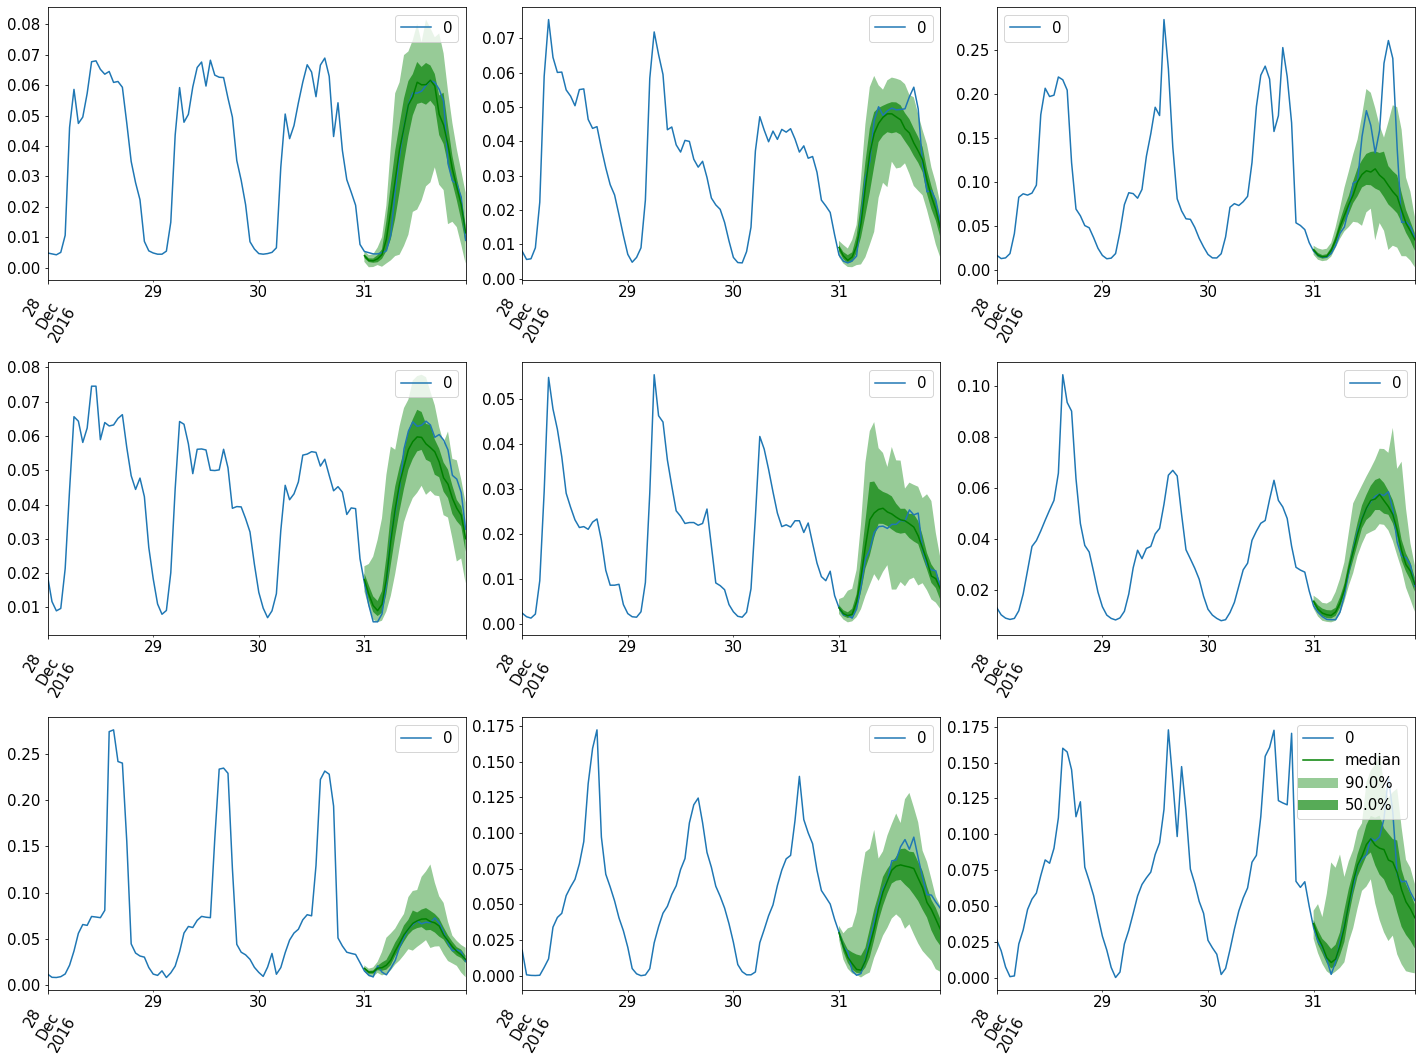

In [272]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * 24:].plot(ax=ax, label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [219]:
# ds 2
agg_metrics

{'MSE': 23.940462105773744,
 'abs_error': 169621.5951450821,
 'abs_target_sum': 795403.1574395448,
 'abs_target_mean': 11.010564194899567,
 'seasonal_error': 2.6968875399609384,
 'MASE': 1.0617574055775507,
 'MAPE': 0.7603387070885905,
 'sMAPE': 0.7029547654975161,
 'MSIS': 13.830274620382172,
 'QuantileLoss[0.1]': 74253.39198404923,
 'Coverage[0.1]': 0.0724390919158361,
 'QuantileLoss[0.2]': 109880.7456878802,
 'Coverage[0.2]': 0.17782392026578073,
 'QuantileLoss[0.3]': 135075.30077576044,
 'Coverage[0.3]': 0.2966362126245847,
 'QuantileLoss[0.4]': 154390.34527562038,
 'Coverage[0.4]': 0.4288759689922481,
 'QuantileLoss[0.5]': 169621.5953532845,
 'Coverage[0.5]': 0.5738372093023256,
 'QuantileLoss[0.6]': 177621.70033670584,
 'Coverage[0.6]': 0.7098560354374307,
 'QuantileLoss[0.7]': 181507.8876448301,
 'Coverage[0.7]': 0.8369462901439645,
 'QuantileLoss[0.8]': 172879.50066934875,
 'Coverage[0.8]': 0.8887181616832779,
 'QuantileLoss[0.9]': 142303.91879960973,
 'Coverage[0.9]': 0.914673

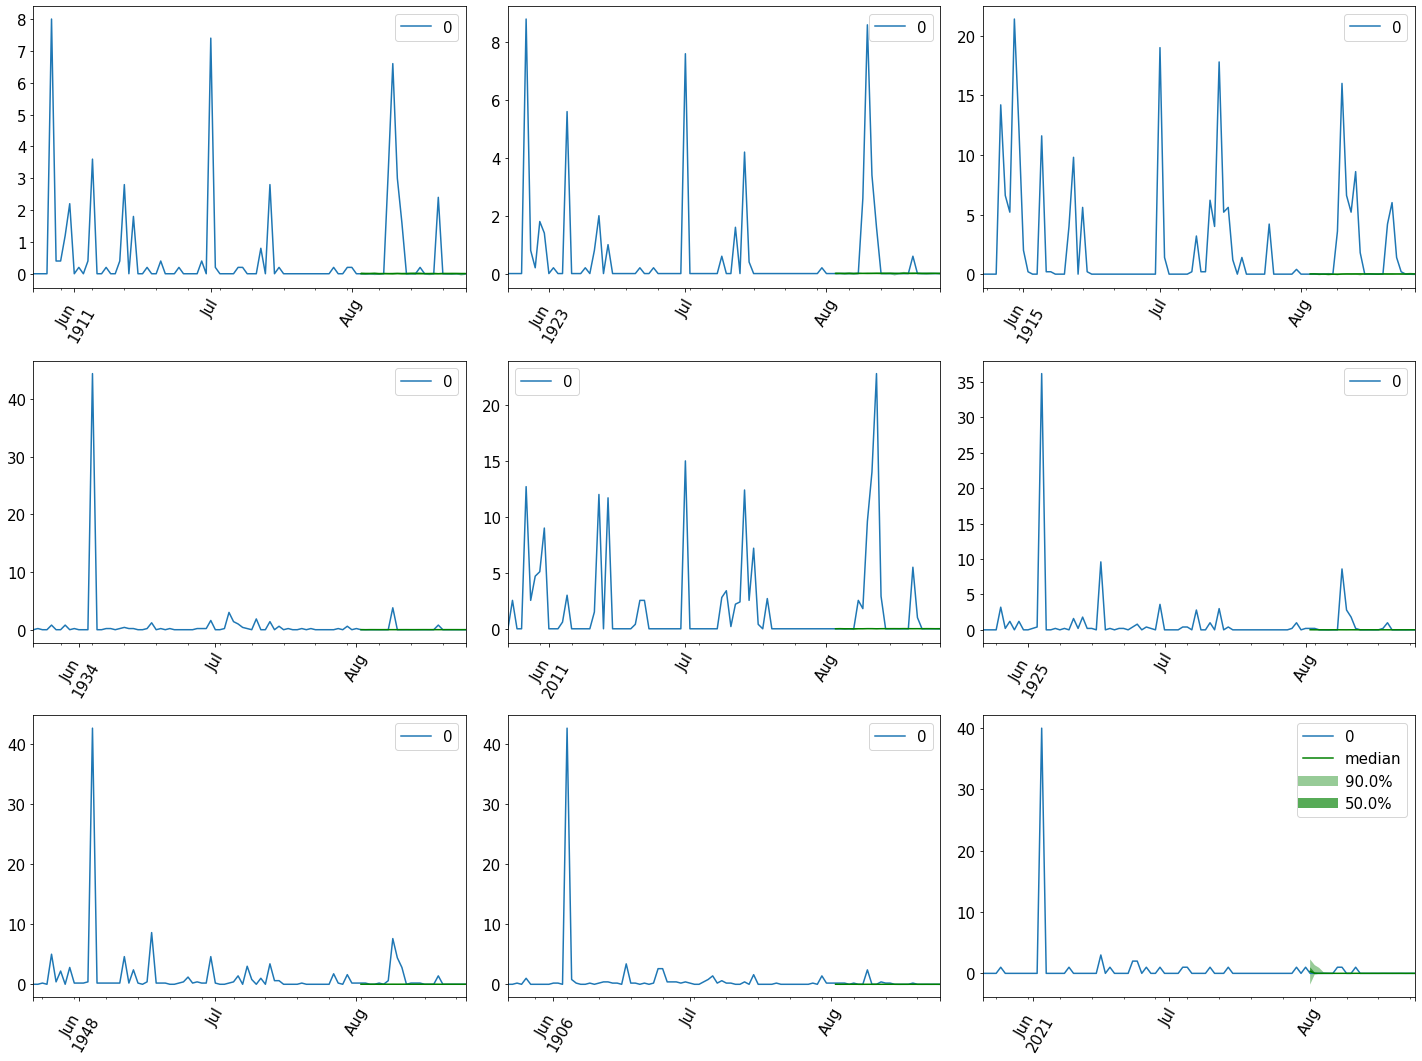

In [113]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * 24:].plot(ax=ax, label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [264]:
# ds 3
agg_metrics

{'MSE': 1115704921.4488733,
 'abs_error': 41362382.66113281,
 'abs_target_sum': 166958474.8984375,
 'abs_target_mean': 19007.112351825763,
 'seasonal_error': 1542.9874709095218,
 'MASE': 2.359203822787185,
 'MAPE': 0.31409288595391543,
 'sMAPE': 0.2854564158832875,
 'MSIS': 18.364880119159142,
 'QuantileLoss[0.1]': 14798822.461064912,
 'Coverage[0.1]': 0.08413023679417121,
 'QuantileLoss[0.2]': 24240270.733774565,
 'Coverage[0.2]': 0.20366575591985428,
 'QuantileLoss[0.3]': 31439739.301414296,
 'Coverage[0.3]': 0.31079234972677594,
 'QuantileLoss[0.4]': 37215963.02638474,
 'Coverage[0.4]': 0.4114298724954464,
 'QuantileLoss[0.5]': 41362383.03600502,
 'Coverage[0.5]': 0.5058060109289617,
 'QuantileLoss[0.6]': 44064631.575115964,
 'Coverage[0.6]': 0.5835610200364298,
 'QuantileLoss[0.7]': 44516753.69809838,
 'Coverage[0.7]': 0.6574453551912568,
 'QuantileLoss[0.8]': 41446041.34827957,
 'Coverage[0.8]': 0.7421448087431693,
 'QuantileLoss[0.9]': 32230755.70360107,
 'Coverage[0.9]': 0.84357

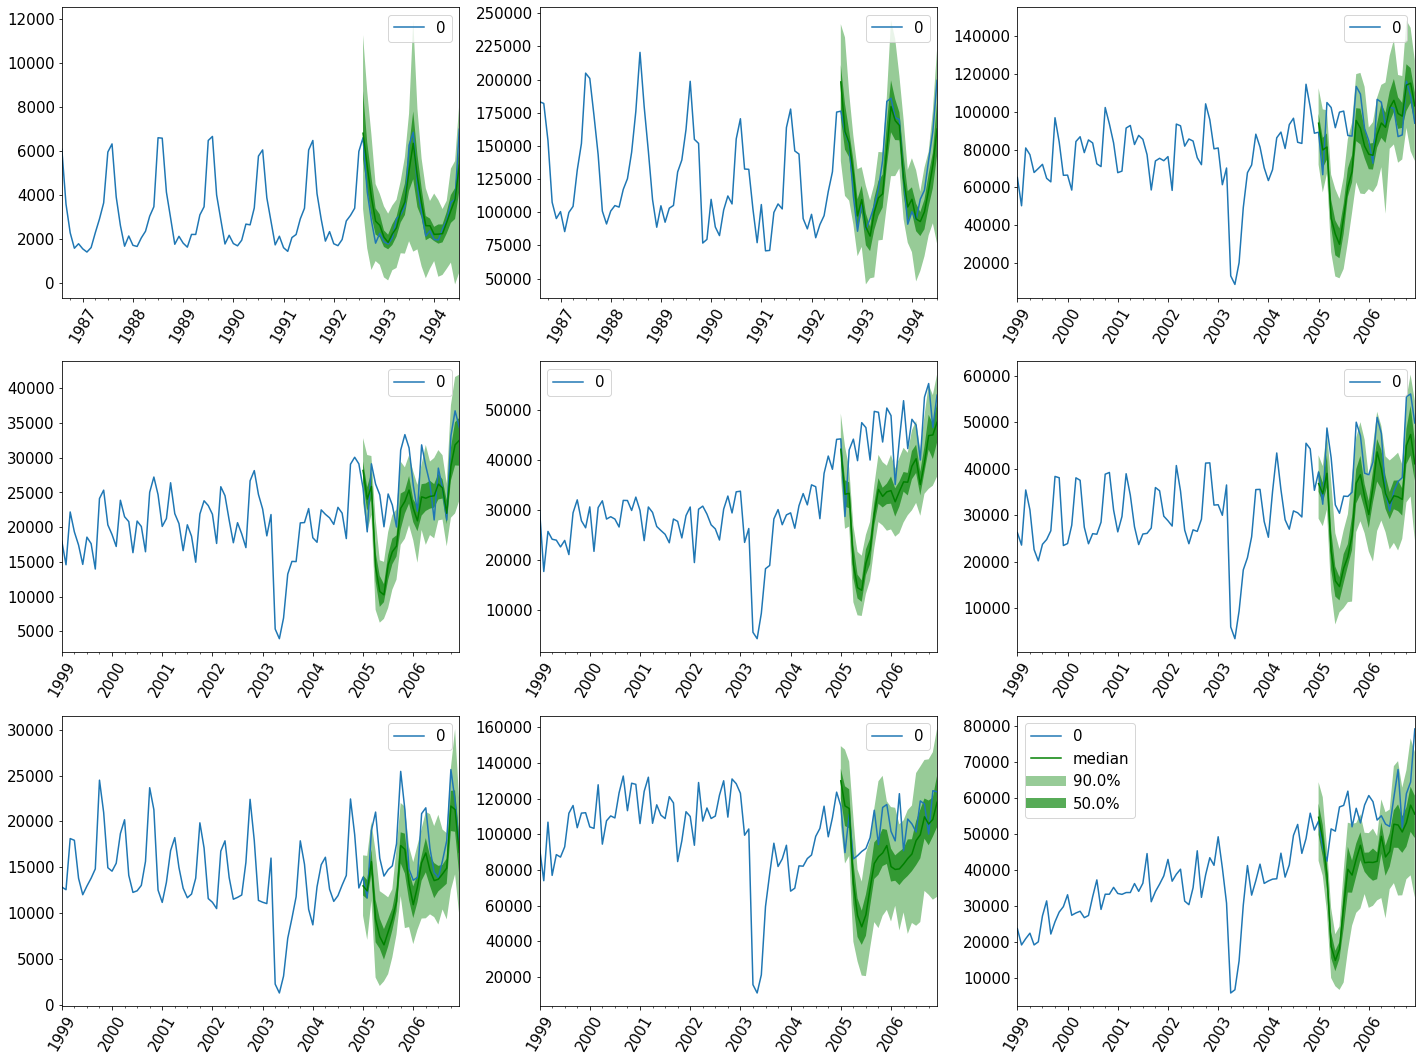

In [265]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * 24:].plot(ax=ax, label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [292]:
# ds 4
agg_metrics

{'MSE': 0.07938089170859768,
 'abs_error': 20232.472963708704,
 'abs_target_sum': 34828.328015925596,
 'abs_target_mean': 0.261003657193687,
 'seasonal_error': 0.12278935134470352,
 'MASE': inf,
 'MAPE': 0.5928652279373905,
 'sMAPE': 0.6665428828939403,
 'MSIS': inf,
 'QuantileLoss[0.1]': 5670.534526125589,
 'Coverage[0.1]': 0.02965377697841726,
 'QuantileLoss[0.2]': 10227.543230812102,
 'Coverage[0.2]': 0.09668764988009591,
 'QuantileLoss[0.3]': 14223.804547135831,
 'Coverage[0.3]': 0.16566247002398082,
 'QuantileLoss[0.4]': 17593.629550595586,
 'Coverage[0.4]': 0.2318195443645084,
 'QuantileLoss[0.5]': 20232.472946430178,
 'Coverage[0.5]': 0.29769184652278174,
 'QuantileLoss[0.6]': 22116.110551246515,
 'Coverage[0.6]': 0.3615857314148681,
 'QuantileLoss[0.7]': 22682.888253401314,
 'Coverage[0.7]': 0.4422661870503597,
 'QuantileLoss[0.8]': 21633.46849227681,
 'Coverage[0.8]': 0.5449790167865708,
 'QuantileLoss[0.9]': 17937.66250043737,
 'Coverage[0.9]': 0.6864583333333334,
 'RMSE': 0.

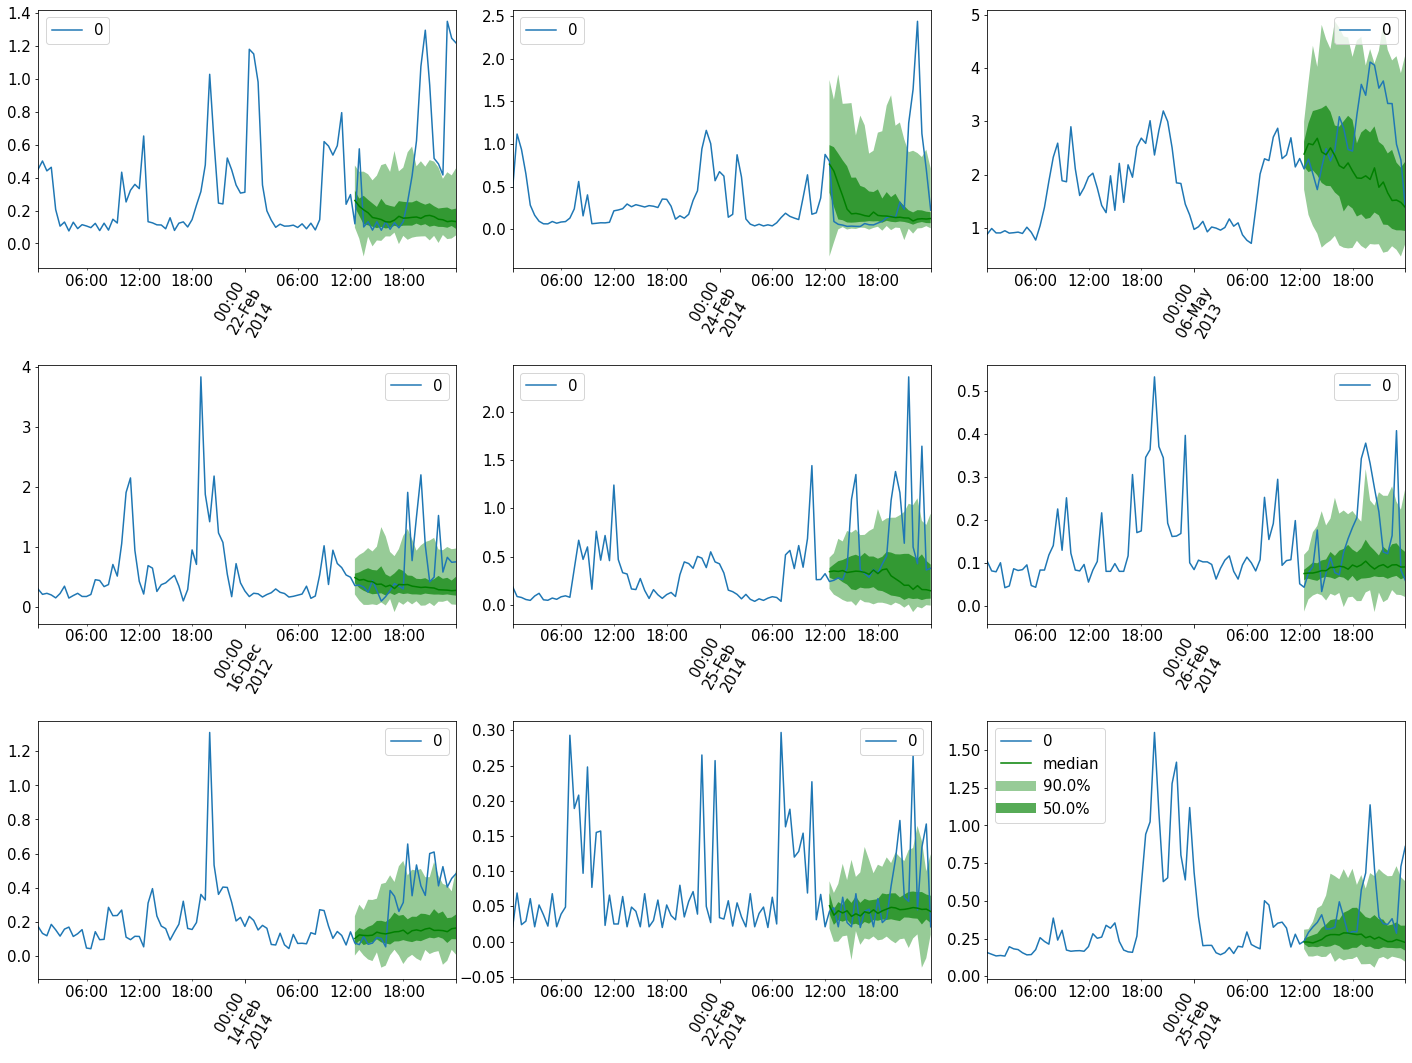

In [293]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)),9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * 24:].plot(ax=ax, label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [273]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 70
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="best")
    plt.show()

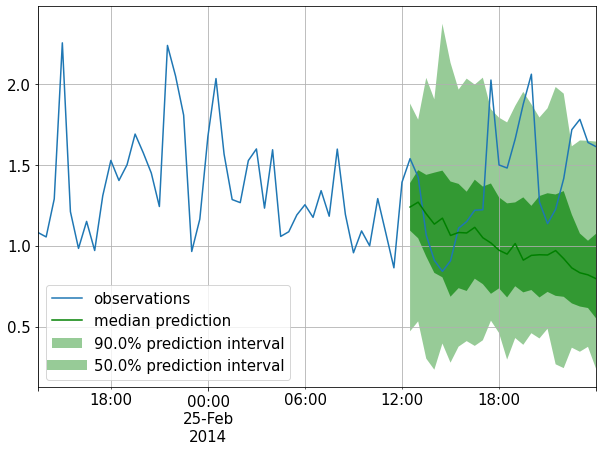

In [300]:
index = 2222
plot_prob_forecasts(tss[index], forecasts[index])